In [1]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from msfm.utils import files, observation, cross_statistics, power_spectra
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting, dataset

# load the $C_\ell$ from the CosmoGrid

# v14

In [2]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"
mocks = ["Buzzard"]
# mocks = ["Buzzard", "Cardinal"]

out_dir = "/pscratch/sd/a/athomsen/run_files/v14"
# out_dir += "/octant"

### clustering

In [3]:
with_lensing = False
with_clustering = True
with_cross_z = True
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]

label = "32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/clustering/smoothing_fwhm/dlss_{label}.yaml"
)

25-06-10 03:06:25 configuratio INF   Loaded the config 


25-06-10 03:06:25 configuratio INF   Loaded the config 
25-06-10 03:06:25 preprocessin INF   Using theta_fwhm = [22.1, 15.1, 11.2, 9.4, 130.2, 88.9, 68.1, 57.0] from the dlss config 
25-06-10 03:06:25 preprocessin INF   Using white_noise_sigma = [0.0010012, 0.0013444, 0.0016358, 0.0017096, 0.85135, 0.34375, 0.25989, 0.24127] from the dlss config 
25-06-10 03:06:25 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-06-10 03:06:25 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
25-06-10 03:06:25 preprocessin INF   Using n_bins = 33 from the msfm config 
25-06-10 03:06:25 preprocessin INF   Loading the pre-binned Cls 
25-06-10 03:06:25 input_output INF   Loading summaries from /pscratch/sd/a/athomsen/v11desy3/v14/extended 
25-06-10 03:06:25 input_output INF   Array shapes: 
25-06-10 03:06:25 input_output INF   fiducial/i_example 

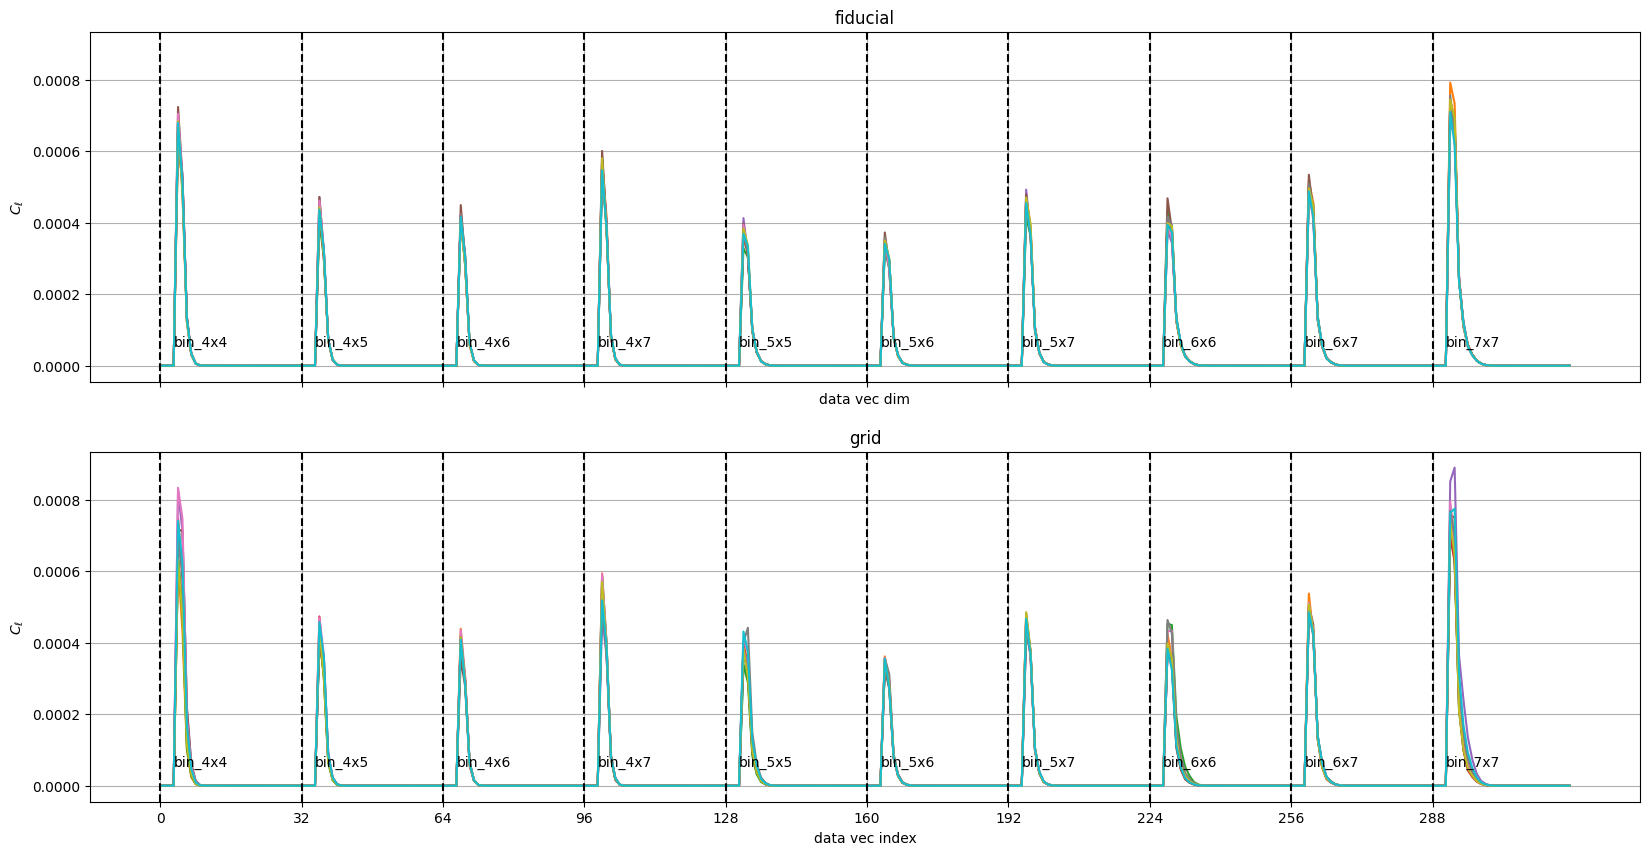

In [4]:
_, _, out_dict = dataset.get_binned_power_spectra_dset(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=with_cross_z,
    with_gaussian_noise=True,
    # dset
    # preprocessing
    apply_log=False,
    standardize=False,
)

In [17]:
i_fidu = 0

fidu_cls = out_dict["fidu/cls"][i_fidu]

print(fidu_cls.shape)

(320,)


# Sanity Check:  load CosmoGrid best fit

In [16]:
cls_dir =  "/pscratch/sd/a/athomsen/run_files/v14/cls/lensing=False,clustering=True,standard=False,log=True,cosine=False,steps=400000/32mpc_sigmoid/likelihood_flow"
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]
bgs = [f"bg{i}" for i in range(1,5)]

fidu_indices = list(range(0, 8))
tomo_bg_fidus = []
for i in fidu_indices:
    chain = np.load(os.path.join(cls_dir, f"chain_fiducial_{i}.npy"))
    log_probs = np.load(os.path.join(cls_dir, f"log_probs_fiducial_{i}.npy"))
    
    MAP_params = chain[np.argmax(log_probs)]
    MAP_dict = {p: np.round(v, 3) for p, v in zip(params, MAP_params)}
    # print(f"MAP parameters: " + str({p: np.round(v, 3) for p, v in zip(params, MAP_params)}))

    tomo_bg_fidus.append([MAP_dict[bg] for bg in bgs])

tomo_bg_fidus = np.stack(tomo_bg_fidus, axis=0)
print(tomo_bg_fidus)

# tomo_bg_fidu = tomo_bg_fidus[i_fidu]

# actual true value, instead of best fit
tomo_bg_fidu = [1.3433586, 1.4218498, 1.4996815, 1.5668583]

[[1.649 1.746 1.867 1.904]
 [1.634 1.756 1.866 1.924]
 [1.615 1.728 1.849 1.896]
 [1.54  1.638 1.728 1.781]
 [1.931 2.039 2.132 2.201]
 [1.205 1.289 1.344 1.423]
 [1.165 1.256 1.354 1.408]
 [1.559 1.682 1.775 1.84 ]]


# forward model maps according to fiducial $C_\ell$ best fit

In [8]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{label}.yaml"
)
cosmogrid_dir = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary"
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"

with_lensing = False
with_clustering = True

25-06-10 03:07:10 configuratio INF   Loaded the config 


In [9]:
cosmo_dir = os.path.join(cosmogrid_dir, "fiducial", "cosmo_fiducial")

cosmogrid_cls = []
for i in tqdm(range(10)):
# for i in tqdm(range(2)):
    perm_dir = os.path.join(cosmo_dir, f"perm_{i:04d}")

    wl_gamma_patch, gc_count_patch = observation.forward_model_cosmogrid(
        perm_dir,
        conf=msfm_conf,
        noisy=True,
        # lensing
        with_lensing=with_lensing,
        tomo_Aia=None,
        bta=None,
        i_sobol=1,
        # clustering
        with_clustering=with_clustering,
        tomo_bg=tomo_bg_fidu,
        noise_seed=12,
    )

    obs_map, obs_cls_raw, footprint_pix = observation.forward_model_observation_map(
        wl_gamma_map=wl_gamma_patch,
        gc_count_map=gc_count_patch,
        conf=msfm_conf,
        # apply_norm=True,
        apply_norm=False,
        with_padding=True,
        nest_in=False,
    )

    if not (with_lensing and with_clustering):
        obs_cls_full = np.zeros((obs_cls_raw.shape[0], 36))

        bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
            with_lensing=with_lensing,
            with_clustering=with_clustering,
            with_cross_z=True,
        )
        
        obs_cls_full[:,bin_indices] = obs_cls_raw

    obs_cls = preprocessing.get_preprocessed_cl_observation(
        obs_cl=obs_cls_full,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        with_cross_probe=(with_lensing and with_clustering),
        # additional preprocessing
        apply_log=False,
        standardize=False,
        # plotting
        make_plot=False,
    )

    cosmogrid_cls.append(obs_cls)

cosmogrid_cls = np.concatenate(cosmogrid_cls, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

25-06-10 03:07:10 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_v11dmb.h5 
25-06-10 03:07:10 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:07:33 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:07:33 observation. INF   No quadratic biasing 
25-06-10 03:07:33 observation. INF   Finished galaxy clustering after 0:00:23.15 
25-06-10 03:07:39 configuratio INF   Loaded the config 
25-06-10 03:07:39 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:07:39 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:07:39 preprocessin INF   Adding white noise to the observation 
25-06-10 03:07:39 preprocessin INF   Using the bin 

 10%|█         | 1/10 [00:29<04:23, 29.26s/it]

25-06-10 03:07:39 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0001/projected_probes_maps_v11dmb.h5 
25-06-10 03:07:39 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:08:02 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:08:02 observation. INF   No quadratic biasing 
25-06-10 03:08:03 observation. INF   Finished galaxy clustering after 0:00:23.66 
25-06-10 03:08:09 configuratio INF   Loaded the config 
25-06-10 03:08:09 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:08:09 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:08:09 preprocessin INF   Adding white noise to the observation 
25-06-10 03:08:09 preprocessin INF   Using the bin 

 20%|██        | 2/10 [00:58<03:55, 29.50s/it]

25-06-10 03:08:09 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0002/projected_probes_maps_v11dmb.h5 
25-06-10 03:08:09 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:08:32 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:08:32 observation. INF   No quadratic biasing 
25-06-10 03:08:33 observation. INF   Finished galaxy clustering after 0:00:23.93 
25-06-10 03:08:38 configuratio INF   Loaded the config 
25-06-10 03:08:38 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:08:38 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:08:39 preprocessin INF   Adding white noise to the observation 
25-06-10 03:08:39 preprocessin INF   Using the bin 

 30%|███       | 3/10 [01:28<03:27, 29.58s/it]

25-06-10 03:08:39 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0003/projected_probes_maps_v11dmb.h5 
25-06-10 03:08:39 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:09:02 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:09:02 observation. INF   No quadratic biasing 
25-06-10 03:09:02 observation. INF   Finished galaxy clustering after 0:00:23.44 
25-06-10 03:09:07 configuratio INF   Loaded the config 
25-06-10 03:09:07 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:09:07 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:09:07 preprocessin INF   Adding white noise to the observation 
25-06-10 03:09:07 preprocessin INF   Using the bin 

 40%|████      | 4/10 [01:57<02:55, 29.27s/it]

25-06-10 03:09:07 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0004/projected_probes_maps_v11dmb.h5 
25-06-10 03:09:07 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:09:29 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:09:29 observation. INF   No quadratic biasing 
25-06-10 03:09:30 observation. INF   Finished galaxy clustering after 0:00:22.47 
25-06-10 03:09:35 configuratio INF   Loaded the config 
25-06-10 03:09:35 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:09:35 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:09:35 preprocessin INF   Adding white noise to the observation 
25-06-10 03:09:35 preprocessin INF   Using the bin 

 50%|█████     | 5/10 [02:25<02:24, 28.83s/it]

25-06-10 03:09:35 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0005/projected_probes_maps_v11dmb.h5 
25-06-10 03:09:35 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:09:58 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:09:58 observation. INF   No quadratic biasing 
25-06-10 03:09:58 observation. INF   Finished galaxy clustering after 0:00:22.94 
25-06-10 03:10:03 configuratio INF   Loaded the config 
25-06-10 03:10:03 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:10:03 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:10:04 preprocessin INF   Adding white noise to the observation 
25-06-10 03:10:04 preprocessin INF   Using the bin 

 60%|██████    | 6/10 [02:53<01:54, 28.69s/it]

25-06-10 03:10:04 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0006/projected_probes_maps_v11dmb.h5 
25-06-10 03:10:04 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:10:26 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:10:26 observation. INF   No quadratic biasing 
25-06-10 03:10:27 observation. INF   Finished galaxy clustering after 0:00:22.93 
25-06-10 03:10:32 configuratio INF   Loaded the config 
25-06-10 03:10:32 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:10:32 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:10:32 preprocessin INF   Adding white noise to the observation 
25-06-10 03:10:32 preprocessin INF   Using the bin 

 70%|███████   | 7/10 [03:22<01:25, 28.57s/it]

25-06-10 03:10:32 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0007/projected_probes_maps_v11dmb.h5 
25-06-10 03:10:32 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:10:55 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:10:55 observation. INF   No quadratic biasing 
25-06-10 03:10:55 observation. INF   Finished galaxy clustering after 0:00:22.93 
25-06-10 03:11:00 configuratio INF   Loaded the config 
25-06-10 03:11:00 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:11:00 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:11:01 preprocessin INF   Adding white noise to the observation 
25-06-10 03:11:01 preprocessin INF   Using the bin 

 80%|████████  | 8/10 [03:50<00:57, 28.52s/it]

25-06-10 03:11:01 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0008/projected_probes_maps_v11dmb.h5 
25-06-10 03:11:01 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:11:23 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:11:23 observation. INF   No quadratic biasing 
25-06-10 03:11:24 observation. INF   Finished galaxy clustering after 0:00:22.85 
25-06-10 03:11:29 configuratio INF   Loaded the config 
25-06-10 03:11:29 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:11:29 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:11:29 preprocessin INF   Adding white noise to the observation 
25-06-10 03:11:29 preprocessin INF   Using the bin 

 90%|█████████ | 9/10 [04:18<00:28, 28.44s/it]

25-06-10 03:11:29 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0009/projected_probes_maps_v11dmb.h5 
25-06-10 03:11:29 observation. INF   Starting with the galaxy clustering map 
25-06-10 03:11:52 observation. INF   Using tomo_bg=[1.3433586, 1.4218498, 1.4996815, 1.5668583] from the function call 
25-06-10 03:11:52 observation. INF   No quadratic biasing 
25-06-10 03:11:52 observation. INF   Finished galaxy clustering after 0:00:23.30 
25-06-10 03:11:57 configuratio INF   Loaded the config 
25-06-10 03:11:57 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-10 03:11:57 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-10 03:11:58 preprocessin INF   Adding white noise to the observation 
25-06-10 03:11:58 preprocessin INF   Using the bin 

100%|██████████| 10/10 [04:47<00:00, 28.76s/it]


In [10]:
cosmogrid_cls.shape

(10, 320)

# plotting

In [11]:
def reshape_full_cls(obs_cls, with_lensing=True, with_clustering=True, concat_bins=True):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]

    if concat_bins:
        obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected

def reshape_probe_cls(obs_cls):
    return np.stack(np.split(obs_cls, 10, axis=-1), axis=-1)    


In [12]:
with_lensing_plot = False
with_clustering_plot = True
n_z = 4 * with_lensing_plot + 4 * with_clustering_plot

# cosmogrid_cls_reshaped = reshape_full_cls(np.squeeze(obs_cls), with_lensing_plot, with_clustering_plot, concat_bins=False)
# buzzard_cls_reshaped = reshape_full_cls(buzzard_cls, with_lensing_plot, with_clustering_plot, concat_bins=False)

cosmogrid_cls_reshaped = reshape_probe_cls(cosmogrid_cls)
fidu_cls_reshaped = reshape_probe_cls(fidu_cls)

bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_cross_z=True,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
current_bins = bins[4:]

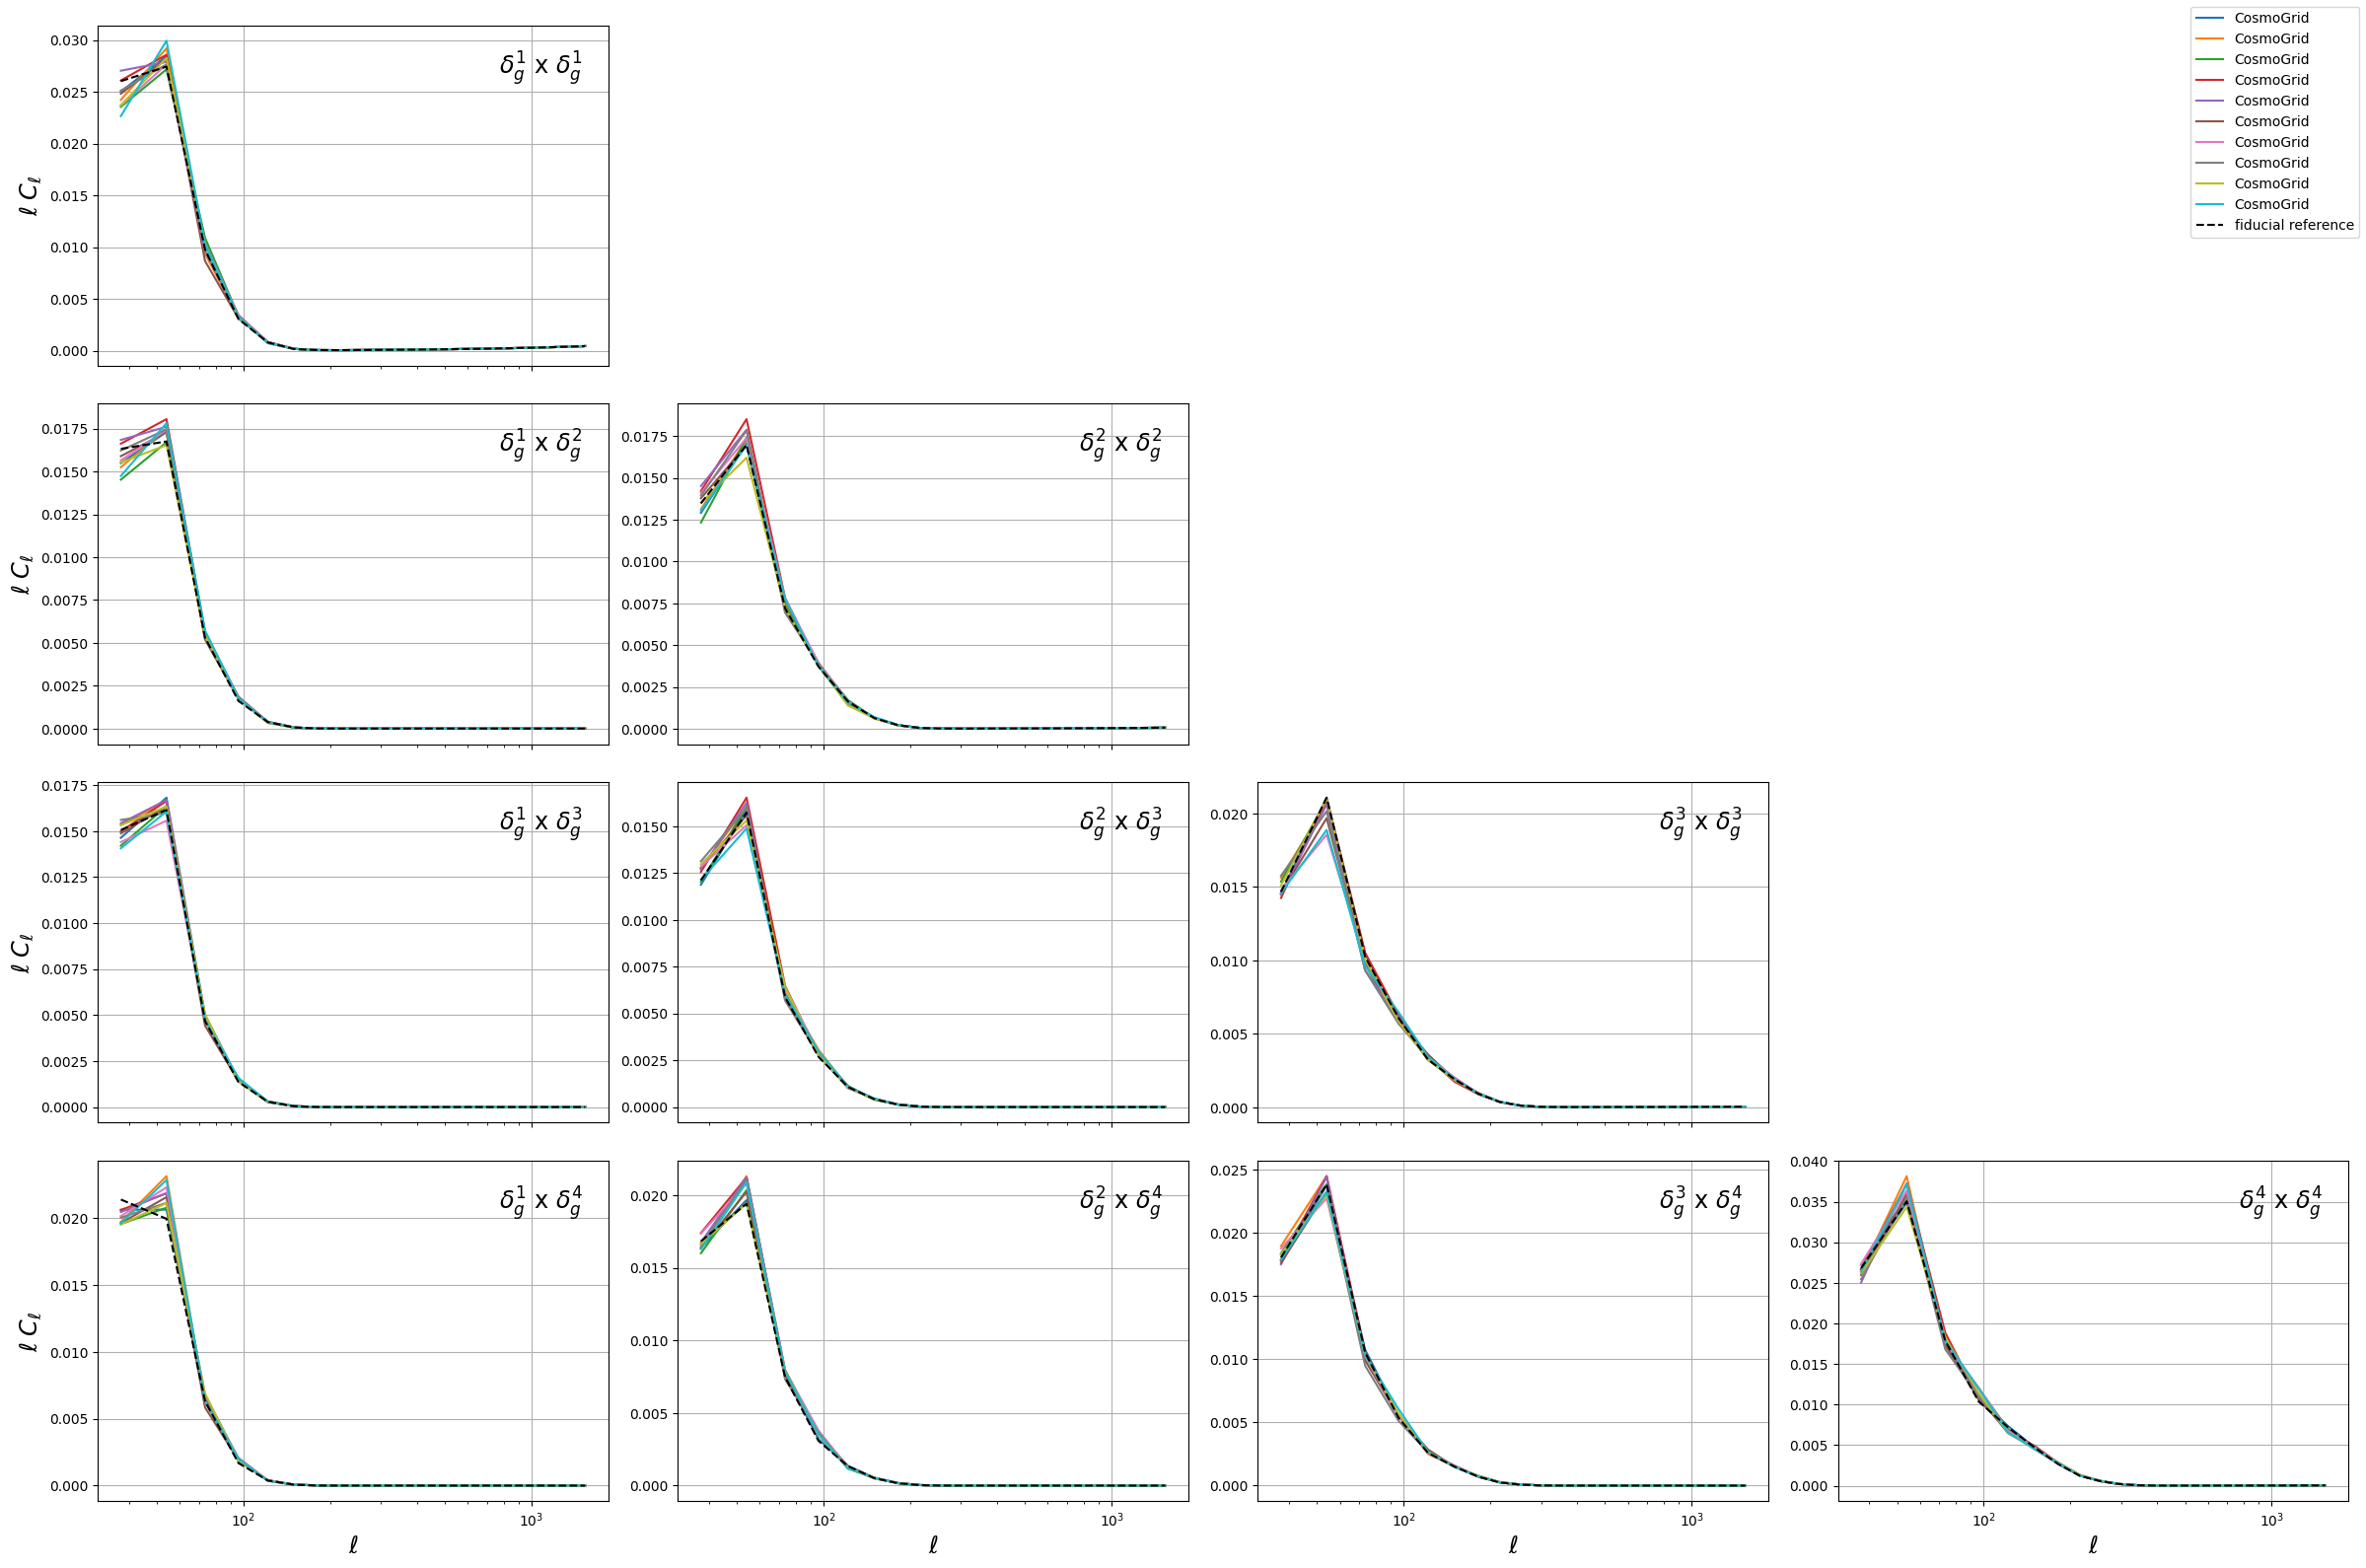

In [15]:
remove_l_min = True
figsize = (24, 16)
fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4

    current_bins = bins[1:]
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
    current_fidu = fidu_cls_reshaped[:, k]
    
    if remove_l_min:
        current_bins = bins[5:]
        current_cosmogrid = current_cosmogrid[4:]
        current_fidu = current_fidu[4:]
    else:
        current_bins = bins[1:]

    if i == 0:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0, label="CosmoGrid") 
        ax[i,j].plot(current_bins, current_bins * current_fidu, color="k", alpha=1.0, linestyle="--", label="fiducial reference")
    else:
        ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0) 
        ax[i,j].plot(current_bins, current_bins * current_fidu, color="k", alpha=1.0, linestyle="--")
    
    # label
    bin_i = rf"\delta_g^{i+1}"
    bin_j = rf"\delta_g^{j+1}"
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 0.93, bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right', va='top'
    )

    # cosmetics
    ax[i, j].set_box_aspect(2 / 3)
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    if i == n_z - 1:
        ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# Turn off upper triangle
for i in range(n_z):
    for j in range(i + 1, n_z):
        ax[i, j].axis('off')

fig.legend()
fig.tight_layout()

fig.savefig(f"plots/cls_test_fidu_{i_fidu}_true.png", bbox_inches="tight", dpi=100)
# fig.savefig(f"plots/cls_test_fidu_{i_fidu}.pdf", bbox_inches="tight")

In [14]:
stop

NameError: name 'stop' is not defined

# trash

In [ ]:
import healpy as hp
from msfm.utils import files

In [ ]:
data_vec_pix, _, _, _ = files.load_pixel_file("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")

In [ ]:
temp = "/pscratch/sd/a/athomsen/v11desy3/v14/extended/obs/cosmo_008963_obs_maps_test.h5"
with h5py.File(temp, "r") as f:
    maps = f["obs/maps"][:]

In [ ]:
n_pix = hp.nside2npix(512)

temp_map = np.zeros((n_pix, 8))
temp_map[data_vec_pix] = maps[0]

In [ ]:
for i in range(8):
    hp.mollview(temp_map[:,i], nest=True, title=i)